# Data Analyst Take Home
## _Explore the Data_

Evaluation of the data quality of the Users, products, and Transactions data sets, followed by data analysis of the fields. The tools used will be Python for pre-processing the unstructured csv files, and then exploring the data using Python and SQL queries.

- [Data Quality Issues](#1)
    - [Users](#2.1)
        - [_Examine Tables - Users_](#2.101)
    - [products](#2.2)
        - [_Examine Tables - products_](#2.201)
    - [Transactions](#2.3)
        - [_Examine Tables - Transactions_](#2.301)
- [Joined Tables - Orphaned Records](#3)


In [2]:
# Import libaries with functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import pandasql as psql
import re
# display max number of columns
pd.set_option("display.max_columns", None)
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

### <a name="1"></a>Data Quality Issues

In [4]:
# Class to use when printing output
class color:
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [5]:
# List csv files to select from
def load_filepaths(directory):
    files = [f for f in os.listdir(directory) if f.endswith(".csv")]
    return files
load_filepaths("../rawdata")

['PRODUCTS_TAKEHOME.csv', 'TRANSACTION_TAKEHOME.csv', 'USER_TAKEHOME.csv']

In [6]:
# Read csv datasets
filepath = "rawdata/"
users = pd.read_csv(filepath + "USER_TAKEHOME.csv")
products = pd.read_csv(filepath + "products_TAKEHOME.csv")
transactions = pd.read_csv(filepath + "TRANSACTION_TAKEHOME.csv")

In [7]:
# Information about the data size and type 
def data_info(data):
    print(color.BOLD + color.UNDERLINE + "\nExamining DataFrame:\n" + color.END)
    print(color.BOLD + "\nData Size:\n" + color.END)
    print(data.shape)
    print(color.BOLD + "\nBasic Information:\n" + color.END)
    print(data.info())
    print(color.BOLD + "First Few Rows in DataFrame:\n" + color.END)
    print(data.head())

In [8]:
# Missing values' count and percentage in each tables
def missing_values(data):
    # Replace empty strings or other placeholders with NaN
    data = data.replace(r'^\s*$', np.nan, regex=True)
    nulls = data.isnull().sum()
    nulls = nulls.reset_index().rename(columns={'index':'Column',0:'cnt'})
    nrows = len(data)
    nulls["perc"] = [round(i/nrows, 2) for i in nulls["cnt"]]
    return nulls
# inspecting the amount of missing is important since some key or important columns may include some/many missing values.

In [9]:
# Plot number of missing values 
def missing_values_plot(table, x, y):
    mv_products = missing_values(table)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=x, y=y)
    plt.title('Missing Values in products Table')
    plt.xlabel('Columns')
    plt.ylabel('Count of Missing Values')
    plt.xticks(rotation=45)
    plt.show()

In [10]:
# Check potential outliers
def outliers_check(table, column):
    plt.boxplot(table[column])
    plt.title(f'Outliers in {column} Column')
    plt.xlabel(f'{column}')  # x-axis label
    plt.ylabel('Values')     # y-axis label representing the data's numeric values
    plt.xticks(rotation=90)
    plt.show()

In [11]:
# Plot a boxplot for numerical data grouped by a categorical column
def barplot_by_category(table, category_column, numeric_column):
    sns.barplot(x=category_column, y=numeric_column, data=table)
    plt.title(f'{numeric_column} by {category_column}')
    plt.xlabel(category_column)
    plt.ylabel(numeric_column)
    plt.xticks(rotation=90)
    plt.show()

In [12]:
# Run SQL query on pandas dataframe
def run_query(query):
    return psql.sqldf(query, globals())

In [13]:
# Preprocess BARCODE column to be an integer or -1 for missing (few values of -1 already). Necessary to clean since it's a key column to match
def preprocess_barcode(table, column):
    bcds = []
    for x in table[column]:
        if x is not None:
            try:
                bcds.append(int(x))
            except:
                bcds.append(-1)
        else:
            bcds.append(-1)
    return bcds

In [14]:
# Preprocess DATE columns to remove unnecessary values from datetime and filter to YYYY-MM-DD format 
# hour, minute, second are excluded for this analysis 
def preprocess_date(table, column):
    # Default date value for the specific date columns
    default_date = '1900-01-01' 
    # Remove letters using regex and keep only date patterns 
    table[column] = table[column].replace(r'[A-Za-z]', '', regex=True)
    # Replace empty if any or NaN entries with the default date
    table[column] = table[column].replace('', np.nan)  
    table[column] = table[column].fillna(default_date) 
    table[column] = table[column].str.slice(0, 10)
    return table[column]

In [15]:
# Distribution of the categorical columns and descriptive statistics of numerical columns
def data_distribution(data):
    dict = {}
    # Loop through each column in the DataFrame
    for column in data.columns:
        # For categorical columns (object type)
        if data[column].dtype == 'object':  
            dict[column] = data[column].value_counts()
        # For numeric columns
        else:  
            dict[column] = data[column].describe()
    
    # Display the results
    for col, stats in dict.items():
        print(color.BOLD + f"\nColumn: {col}" + color.END)
        print(stats)

### <a name="2.1"></a>Users

In [17]:
# Explore data
data_info(users)


Examining DataFrame:


Data Size:

(100000, 6)

Basic Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   ID            100000 non-null  object
 1   CREATED_DATE  100000 non-null  object
 2   BIRTH_DATE    96325 non-null   object
 3   STATE         95188 non-null   object
 4   LANGUAGE      69492 non-null   object
 5   GENDER        94108 non-null   object
dtypes: object(6)
memory usage: 4.6+ MB
None
First Few Rows in DataFrame:

                         ID               CREATED_DATE  \
0  5ef3b4f17053ab141787697d  2020-06-24 20:17:54.000 Z   
1  5ff220d383fcfc12622b96bc  2021-01-03 19:53:55.000 Z   
2  6477950aa55bb77a0e27ee10  2023-05-31 18:42:18.000 Z   
3  658a306e99b40f103b63ccf8  2023-12-26 01:46:22.000 Z   
4  653cf5d6a225ea102b7ecdc2  2023-10-28 11:51:50.000 Z   

                  BIRTH_DATE STATE LANGUAGE  GENDER  


In [18]:
# Missing counts and percentage for Users
missing_values(users)

,Column,cnt,perc
0,ID,0,0.00
1,CREATED_DATE,0,0.00
2,BIRTH_DATE,3675,0.04
3,STATE,4812,0.05
4,LANGUAGE,30508,0.31
5,GENDER,5892,0.06


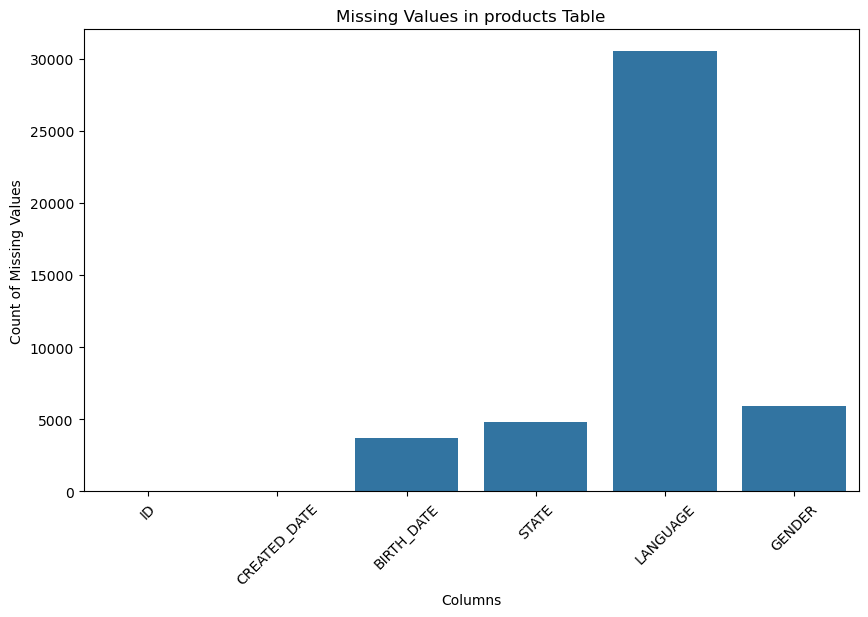

In [19]:
# Plot missing values
mv_users = missing_values(users)
missing_values_plot(mv_users, mv_users.Column, mv_users.cnt)

In [20]:
# Query for duplicates by id, which is Primary Key so shouldn't have any
users_dups = "SELECT id, COUNT(*) as CNT FROM users GROUP BY id HAVING COUNT(*) > 1;"
run_query(users_dups)

,ID,CNT


In [21]:
# Query duplicates based on created_date and birth_date 
query_duplicates_created_date = """
    WITH date_dups_CTE AS (
        SELECT created_date, birth_date, COUNT(*)
        FROM users
        GROUP BY created_date, birth_date
        HAVING COUNT(*) > 1
    ) 
    SELECT u.CREATED_DATE, u.BIRTH_DATE, u.STATE, u.LANGUAGE, u.GENDER
    FROM date_dups_CTE d
    JOIN users u ON d.CREATED_DATE=u.CREATED_DATE
"""
run_query(query_duplicates_created_date)

,CREATED_DATE,BIRTH_DATE,STATE,LANGUAGE,GENDER
0,2023-11-24 15:29:51.000 Z,None,NY,en,None
1,2023-11-24 15:29:51.000 Z,None,TX,en,None


In [22]:
# Clean date from the datetime columns
users_clean = users
users_clean["CREATED_DATE"] = preprocess_date(users_clean, "CREATED_DATE")
users_clean["BIRTH_DATE"] = preprocess_date(users_clean, "BIRTH_DATE")
users_clean.head()

,ID,CREATED_DATE,BIRTH_DATE,STATE,LANGUAGE,GENDER
0,5ef3b4f17053ab141787697d,2020-06-24,2000-08-11,CA,es-419,female
1,5ff220d383fcfc12622b96bc,2021-01-03,2001-09-24,PA,en,female
2,6477950aa55bb77a0e27ee10,2023-05-31,1994-10-28,FL,es-419,female
3,658a306e99b40f103b63ccf8,2023-12-26,1900-01-01,NC,en,NaN
4,653cf5d6a225ea102b7ecdc2,2023-10-28,1972-03-19,PA,en,female


In [23]:
# Query for invalid dates (created or birth date is after today)
query_invalid_users_dates = "SELECT * FROM users_clean WHERE created_date > DATE('now') OR birth_date > DATE('now');"
run_query(query_invalid_users_dates)

,ID,CREATED_DATE,BIRTH_DATE,STATE,LANGUAGE,GENDER


In [24]:
# Get descriptive statistics and value counts of Users table
data_distribution(users_clean)


Column: ID
ID
5ef3b4f17053ab141787697d    1
5f889d85746cfc1620c10130    1
5dc6eb9192ad0e12e283bcb2    1
5f1de98e57441c14b826b270    1
5efe2d8d6e0151146c9a31bc    1
                           ..
66caa561ceb005043d74acf3    1
604b67b40134cc12de1361fb    1
66a156f8465f309038b30946    1
5fc5d3b4a071f3282e52f0c6    1
5e7ab436905e9512ff44abc8    1
Name: count, Length: 100000, dtype: int64

Column: CREATED_DATE
CREATED_DATE
2020-12-13    224
2024-09-11    200
2024-09-10    191
2024-07-29    189
2022-06-15    172
             ... 
2016-04-05      1
2017-12-03      1
2018-05-27      1
2018-03-21      1
2016-04-15      1
Name: count, Length: 2783, dtype: int64

Column: BIRTH_DATE
BIRTH_DATE
1900-01-01    3677
1970-01-01    1280
1979-12-11      66
2000-12-12      41
2000-12-31      37
              ... 
1952-10-20       1
1946-10-25       1
2008-09-14       1
2009-01-16       1
2010-04-29       1
Name: count, Length: 21819, dtype: int64

Column: STATE
STATE
TX    9028
FL    8921
CA    8589
NY   

In [25]:
# Save users_clean to load to Database
users_clean.to_csv("output/users_clean.csv", index=False)

#### <a name="2.101"></a>_Examine Tables - Users_
- Users data included 100000 rows with ID as the Primary Key, and variables of CREATED_DATE, BIRTH_DATE, STATE, LANGUAGE, and GENDER 
- There were around 4-6% of missing data in BIRTH_DATE, STATE, and GENDER. However, LANGUAGE had 31% missing and only 2 (63403 en & 6089 es-419)
- There weren't any duplicates when checking the id, but there are some for created_date with different birth dates. There is one for same dates but the birth date is missing.
- The dates were also checked for invalid if it's after today. There were no invalid dates.
- The descriptive statistics and the value counts were collected for all the columns giving insights of the most common dates, states, and gender.

### <a name="2.2"></a>Products

In [28]:
# Explore data
data_info(products)


Examining DataFrame:


Data Size:

(845552, 7)

Basic Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 845552 entries, 0 to 845551
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   CATEGORY_1    845441 non-null  object 
 1   CATEGORY_2    844128 non-null  object 
 2   CATEGORY_3    784986 non-null  object 
 3   CATEGORY_4    67459 non-null   object 
 4   MANUFACTURER  619078 non-null  object 
 5   BRAND         619080 non-null  object 
 6   BARCODE       841527 non-null  float64
dtypes: float64(1), object(6)
memory usage: 45.2+ MB
None
First Few Rows in DataFrame:

          CATEGORY_1              CATEGORY_2                   CATEGORY_3  \
0  Health & Wellness           Sexual Health  Conductivity Gels & Lotions   
1             Snacks           Puffed Snacks         Cheese Curls & Puffs   
2  Health & Wellness               Hair Care        Hair Care Accessories   
3  Health & Wellness         

In [29]:
# Missing counts and percentage for products
missing_values(products)

,Column,cnt,perc
0,CATEGORY_1,111,0.00
1,CATEGORY_2,1424,0.00
2,CATEGORY_3,60566,0.07
3,CATEGORY_4,778093,0.92
4,MANUFACTURER,226474,0.27
5,BRAND,226472,0.27
6,BARCODE,4025,0.00


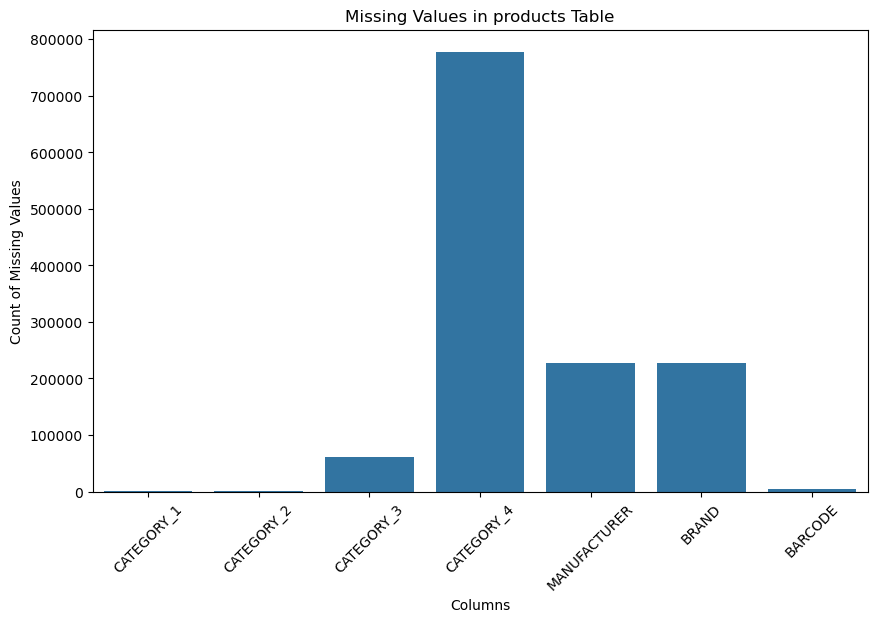

In [30]:
# Plot missing values
mv_products = missing_values(products)
missing_values_plot(mv_products, mv_products.Column, mv_products.cnt)

In [31]:
# BARCODE column converted to integer, to match with transactions table's BARCODE Foreign Key 
products["BARCODE"] = preprocess_barcode(products, "BARCODE")

In [32]:
# Query for duplicates by BARCODE, but has 186 duplicates
products_dups = "SELECT barcode, COUNT(*) FROM products GROUP BY barcode HAVING COUNT(*) > 1;"
run_query(products_dups)

,BARCODE,COUNT(*)
0,-1,4025
1,400510,2
2,404310,2
3,438711,2
4,563178,2
...,...,...
181,87317466,2
182,87317527,2
183,360054002,2
184,17000329260,2


In [33]:
# Check how many barcodes are missing or have a duplicate 
run_query(products_dups)["COUNT(*)"].value_counts()

COUNT(*)
2       185
4025      1
Name: count, dtype: int64

In [34]:
# Remove BARCODE of -1 as it's the primary key
products_clean = products[products["BARCODE"] != -1]
products_clean.shape

(841527, 7)

In [35]:
# Query full duplicates 
query_duplicates_full = """
    SELECT CATEGORY_1, CATEGORY_2, CATEGORY_3, CATEGORY_4, MANUFACTURER, BRAND, BARCODE,
    COUNT(*) as count
    FROM products_clean
    GROUP BY CATEGORY_1, CATEGORY_2, CATEGORY_3, CATEGORY_4, MANUFACTURER, BRAND, BARCODE
    HAVING COUNT(*) > 1;
"""
run_query(query_duplicates_full)

,CATEGORY_1,CATEGORY_2,CATEGORY_3,CATEGORY_4,MANUFACTURER,BRAND,BARCODE,count
0,Beverages,Carbonated Soft Drinks,Cola,Regular Cola,THE COCA-COLA COMPANY,COCA-COLA,4904403,2
1,Health & Wellness,Skin Care,Lip Balms & Treatments,Medicated Lip Treatments,BLISTEX INC,BLISTEX,4138891,2
2,Snacks,Candy,Chocolate Candy,None,None,None,20012274,2
3,Snacks,Candy,Chocolate Candy,None,None,None,20177195,2
4,Snacks,Candy,Chocolate Candy,None,None,None,20259044,2
...,...,...,...,...,...,...,...,...
153,Snacks,Nuts & Seeds,Mixed Nuts,None,None,None,20707361,2
154,Snacks,Nuts & Seeds,Mixed Nuts,None,None,None,20866358,2
155,Snacks,Nuts & Seeds,Mixed Nuts,None,GHIRARDELLI CHOCOLATE COMPANY,GHIRARDELLI,13468439,2
156,Snacks,Nuts & Seeds,Peanuts,None,None,None,3415207,2


In [36]:
# Query remove duplicates 
products_clean = products_clean.drop_duplicates(subset="BARCODE")
products_clean.shape

(841342, 7)

In [37]:
# Get descriptive statistics and value counts of products table
data_distribution(products_clean)


Column: CATEGORY_1
CATEGORY_1
Health & Wellness         510382
Snacks                    323018
Beverages                   3977
Pantry                       867
Apparel & Accessories        840
Dairy                        592
Needs Review                 547
Alcohol                      475
Home & Garden                115
Deli & Bakery                 66
Frozen                        62
Meat & Seafood                49
Sporting Goods                47
Office & School               45
Restaurant                    35
Toys & Games                  28
Household Supplies            24
Produce                       20
Animals & Pet Supplies        16
Arts & Entertainment           7
Electronics                    5
Mature                         3
Vehicles & Parts               3
Baby & Toddler                 3
Beauty                         2
Media                          2
Luggage & Bags                 1
Name: count, dtype: int64

Column: CATEGORY_2
CATEGORY_2
Candy                

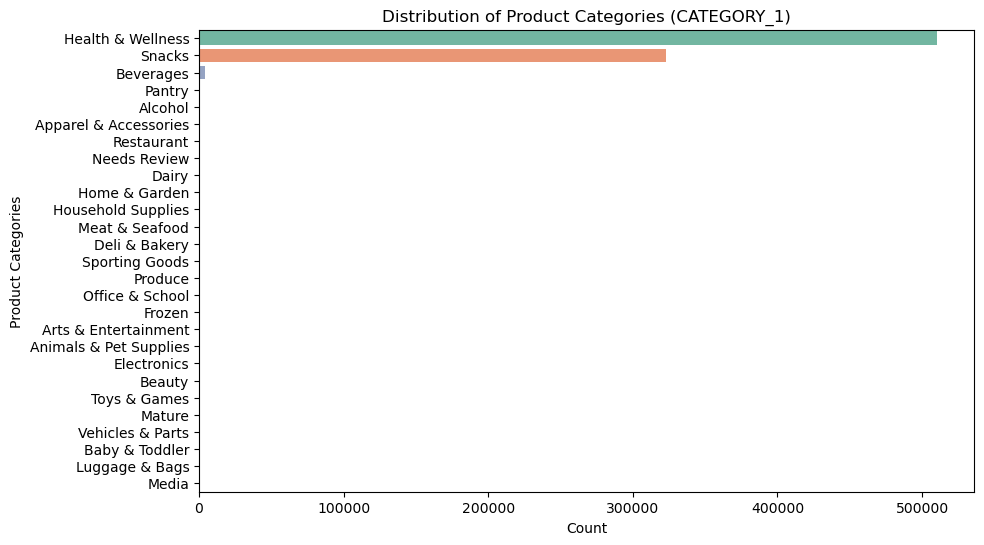

In [38]:
# Plot distribution of CATEGORY_1, for exmaple, shows highly skewed towards Health & Wellness and Snacks (irony..)
plt.figure(figsize=(10, 6))
sns.countplot(y='CATEGORY_1', data=products_clean, palette='Set2')
plt.title('Distribution of Product Categories (CATEGORY_1)')
plt.xlabel('Count')
plt.ylabel('Product Categories')
plt.show()


In [39]:
# Find unique values in each category
category_1_items = products_clean['CATEGORY_1'].unique()
category_2_items = products_clean['CATEGORY_2'].unique()
category_3_items = products_clean['CATEGORY_3'].unique()
category_4_items = products_clean['CATEGORY_4'].unique()

# Create a dictionary of the unique values
unique_categories = {
    'CATEGORY_1': category_1_items,
    'CATEGORY_2': category_2_items,
    'CATEGORY_3': category_3_items,
    'CATEGORY_4': category_4_items
}

# Print unique values for comparison
for category, values in unique_categories.items():
    print(f"{category}: {values}")
    print()

CATEGORY_1: ['Health & Wellness' 'Snacks' 'Beverages' 'Pantry' 'Alcohol'
 'Apparel & Accessories' 'Restaurant' 'Needs Review' 'Dairy'
 'Home & Garden' nan 'Household Supplies' 'Meat & Seafood' 'Deli & Bakery'
 'Sporting Goods' 'Produce' 'Office & School' 'Frozen'
 'Arts & Entertainment' 'Animals & Pet Supplies' 'Electronics' 'Beauty'
 'Toys & Games' 'Mature' 'Vehicles & Parts' 'Baby & Toddler'
 'Luggage & Bags' 'Media']

CATEGORY_2: ['Sexual Health' 'Puffed Snacks' 'Hair Care' 'Oral Care'
 'Medicines & Treatments' 'Deodorant & Antiperspirant' 'Snack Bars'
 'Bath & Body' 'Nuts & Seeds' 'Candy' 'Cookies' 'Variety Snack Packs'
 'Hair Removal' 'Medical Supplies & Equipment' 'Chips' 'Snack Cakes'
 'Skin Care' 'Dessert Toppings' 'Eye Care' 'Fruit & Vegetable Snacks'
 'Snack Mixes' 'Crackers' 'Jerky & Dried Meat'
 'Topical Muscle & Joint Relief Treatments' 'Foot Care' 'First Aid'
 'Ear Care' 'Menstrual Care' 'Pretzels' 'Trail Mix' 'Dips & Salsa'
 'Adult Incontinence' 'Water' 'Cereal, Granola,

In [40]:
# Save products to load to Database
products_clean.to_csv("output/products_clean.csv", index=False)

### <a name="2.201"></a>_Examine Tables - products_
- Product table included 845552 rows of all categorical variables along with Barcode. The text in the Category columns looked similar for most rows and the fields aren't defined either so it would be difficult to analyze.
- The missing values were counted and graphed, showing Category_4 with the most missing (92%), followed by Manufacturer and Brands (both 27%), and Category_3 (7%).
- Barcode was converted to an integer to be able to join with Transactions table accurately, since they're linked.
- As checking the duplicates, there were duplicates based on only barcode. There were 185 duplicated barcodes and 4025 missing barcodes. While checking, there were 185 full records duplicated.
- Data distrubution showed the most popular Brands, Manufacturers, and the Categoris. 


### <a name="2.3"></a>Transactions

In [43]:
# Explore data
data_info(transactions)


Examining DataFrame:


Data Size:

(50000, 8)

Basic Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RECEIPT_ID      50000 non-null  object 
 1   PURCHASE_DATE   50000 non-null  object 
 2   SCAN_DATE       50000 non-null  object 
 3   STORE_NAME      50000 non-null  object 
 4   USER_ID         50000 non-null  object 
 5   BARCODE         44238 non-null  float64
 6   FINAL_QUANTITY  50000 non-null  object 
 7   FINAL_SALE      50000 non-null  object 
dtypes: float64(1), object(7)
memory usage: 3.1+ MB
None
First Few Rows in DataFrame:

                             RECEIPT_ID PURCHASE_DATE  \
0  0000d256-4041-4a3e-adc4-5623fb6e0c99    2024-08-21   
1  0001455d-7a92-4a7b-a1d2-c747af1c8fd3    2024-07-20   
2  00017e0a-7851-42fb-bfab-0baa96e23586    2024-08-18   
3  000239aa-3478-453d-801e-66a82e39c8af    2024-06-18   
4 

In [44]:
# Missing counts and percentage for Transactions
missing_values(transactions)

,Column,cnt,perc
0,RECEIPT_ID,0,0.00
1,PURCHASE_DATE,0,0.00
2,SCAN_DATE,0,0.00
3,STORE_NAME,0,0.00
4,USER_ID,0,0.00
5,BARCODE,5762,0.12
6,FINAL_QUANTITY,0,0.00
7,FINAL_SALE,12500,0.25


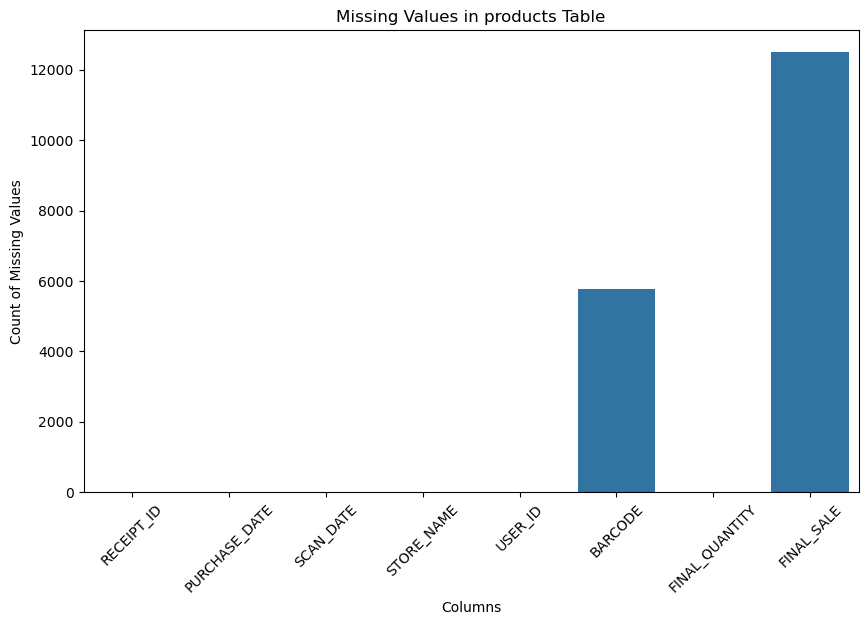

In [45]:
# Plot missing values
mv_transactions = missing_values(transactions)
missing_values_plot(mv_transactions, mv_transactions.Column, mv_transactions.cnt)

In [46]:
# BARCODE column converted to integer, to match with products table's BARCODE 
transactions["BARCODE"] = preprocess_barcode(transactions, "BARCODE")

In [47]:
# Check Dates format
transactions.filter(regex="DATE").sample(2)

,PURCHASE_DATE,SCAN_DATE
31444,2024-08-26,2024-08-29 08:49:06.414 Z
43653,2024-07-08,2024-07-08 11:55:59.586 Z


In [48]:
# Convert SCAN_DATE to YYYY-MM-DD
transactions["SCAN_DATE"] = preprocess_date(transactions, "SCAN_DATE")

In [49]:
# Query for duplicates by RECEIPT_ID, which has 24440 duplicates
transactions_dups = "SELECT receipt_id, COUNT(*) FROM transactions GROUP BY receipt_id HAVING COUNT(*) > 1;"
run_query(transactions_dups)

,RECEIPT_ID,COUNT(*)
0,0000d256-4041-4a3e-adc4-5623fb6e0c99,2
1,0001455d-7a92-4a7b-a1d2-c747af1c8fd3,2
2,00017e0a-7851-42fb-bfab-0baa96e23586,2
3,000239aa-3478-453d-801e-66a82e39c8af,2
4,00026b4c-dfe8-49dd-b026-4c2f0fd5c6a1,2
...,...,...
24435,fff60bb7-bf93-4e6b-8055-4d7688da7ead,2
24436,fff6c6c8-e002-4262-85ea-25849d9721db,2
24437,fffbb112-3cc5-47c2-b014-08db2f87e0c7,2
24438,fffbfb2a-7c1f-41c9-a5da-628fa7fcc746,2


In [50]:
# Query for duplicates by RECEIPT_ID, USER_ID, BARCODE which has 24795 duplicates
transactions_dups = "SELECT receipt_id, user_id, barcode, COUNT(*) FROM transactions GROUP BY receipt_id, user_id, barcode HAVING COUNT(*) > 1;"
run_query(transactions_dups)

,RECEIPT_ID,USER_ID,BARCODE,COUNT(*)
0,0000d256-4041-4a3e-adc4-5623fb6e0c99,63b73a7f3d310dceeabd4758,15300014978,2
1,0001455d-7a92-4a7b-a1d2-c747af1c8fd3,62c08877baa38d1a1f6c211a,-1,2
2,00017e0a-7851-42fb-bfab-0baa96e23586,60842f207ac8b7729e472020,78742229751,2
3,000239aa-3478-453d-801e-66a82e39c8af,63fcd7cea4f8442c3386b589,783399746536,2
4,00026b4c-dfe8-49dd-b026-4c2f0fd5c6a1,6193231ae9b3d75037b0f928,47900501183,2
...,...,...,...,...
24790,fff60bb7-bf93-4e6b-8055-4d7688da7ead,5eb887f71699c213b1abe2e1,78742213224,2
24791,fff6c6c8-e002-4262-85ea-25849d9721db,6220b111e9e82c0c6bc24534,78742369822,2
24792,fffbb112-3cc5-47c2-b014-08db2f87e0c7,5eb59d6be7012d13941af5e2,818000020115,2
24793,fffbfb2a-7c1f-41c9-a5da-628fa7fcc746,62a0c8f7d966665570351bb8,13000009546,2


In [51]:
# Remove the duplicates of transactions and keep max FINAL_QUANTITY, FINAL_SALE in correct format
transactions_clean_query = """
    SELECT RECEIPT_ID, PURCHASE_DATE, SCAN_DATE, STORE_NAME, USER_ID, BARCODE, 
    CASE WHEN LOWER(FINAL_QUANTITY) = 'zero' THEN 0 ELSE CAST(FINAL_QUANTITY AS DECIMAL(10, 2)) END AS FINAL_QUANTITY, 
    CASE WHEN TRIM(FINAL_SALE) = '' THEN 0 ELSE CAST(FINAL_SALE AS DECIMAL(10, 2)) END AS FINAL_SALE 
    FROM transactions;
    """
transactions_clean = run_query(transactions_clean_query)
transactions_clean_query = """
    SELECT RECEIPT_ID, PURCHASE_DATE, SCAN_DATE, STORE_NAME, USER_ID, BARCODE, 
    MAX(FINAL_QUANTITY) as FINAL_QUANTITY, MAX(FINAL_SALE) as FINAL_SALE 
    FROM transactions_clean 
    GROUP BY RECEIPT_ID, PURCHASE_DATE, SCAN_DATE, STORE_NAME, USER_ID, BARCODE;
    """
transactions_clean = run_query(transactions_clean_query)

In [52]:
print("Transactions table after removing duplicates:\n", transactions_clean.shape)
transactions_clean.head()

Transactions table after removing duplicates:
 (24795, 8)


,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE
0,0000d256-4041-4a3e-adc4-5623fb6e0c99,2024-08-21,2024-08-21,WALMART,63b73a7f3d310dceeabd4758,15300014978,1.0,1.54
1,0001455d-7a92-4a7b-a1d2-c747af1c8fd3,2024-07-20,2024-07-20,ALDI,62c08877baa38d1a1f6c211a,-1,1.0,1.49
2,00017e0a-7851-42fb-bfab-0baa96e23586,2024-08-18,2024-08-19,WALMART,60842f207ac8b7729e472020,78742229751,1.0,2.54
3,000239aa-3478-453d-801e-66a82e39c8af,2024-06-18,2024-06-19,FOOD LION,63fcd7cea4f8442c3386b589,783399746536,1.0,3.49
4,00026b4c-dfe8-49dd-b026-4c2f0fd5c6a1,2024-07-04,2024-07-05,RANDALLS,6193231ae9b3d75037b0f928,47900501183,1.0,5.29


In [53]:
# Missing counts and percentage for cleaned Transactions table
missing_values(transactions_clean)

,Column,cnt,perc
0,RECEIPT_ID,0,0.0
1,PURCHASE_DATE,0,0.0
2,SCAN_DATE,0,0.0
3,STORE_NAME,0,0.0
4,USER_ID,0,0.0
5,BARCODE,0,0.0
6,FINAL_QUANTITY,0,0.0
7,FINAL_SALE,0,0.0


In [54]:
# Remove BARCODE of -1 as it's the primary key
transactions_clean = transactions_clean[transactions_clean["BARCODE"] != -1]
transactions_clean.shape

(21975, 8)


Top 5 Stores:


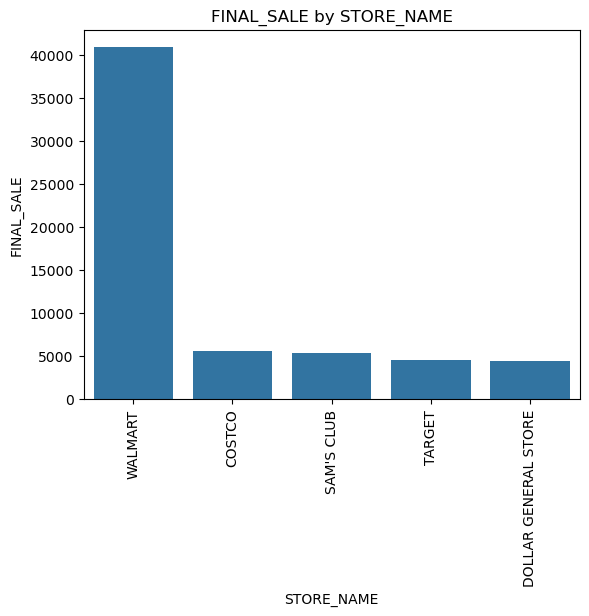

In [55]:
# Plot the barplot total FINAL_SALE for the top 5 Stores
transactions_top5sales_query = """
    SELECT STORE_NAME, SUM(FINAL_SALE) as FINAL_SALE, SUM(FINAL_QUANTITY) as FINAL_QUANTITY 
    FROM transactions_clean GROUP BY STORE_NAME ORDER BY FINAL_SALE DESC LIMIT 5
    """
transactions_top5sales = run_query(transactions_top5sales_query)
print(color.BOLD + color.UNDERLINE + "\nTop 5 Stores:" + color.END)
barplot_by_category(transactions_top5sales, "STORE_NAME", "FINAL_SALE")


Monthly Sales:


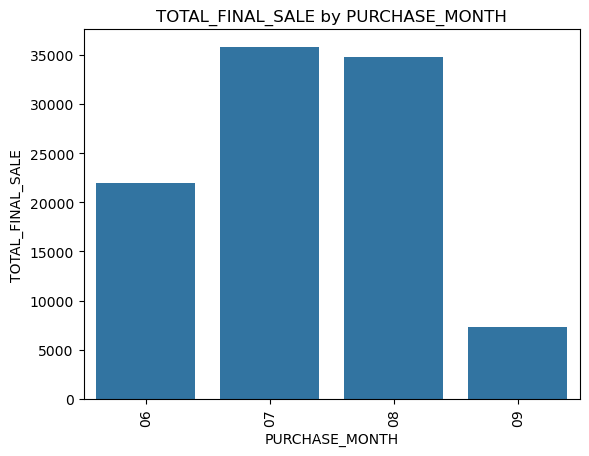

In [56]:
# Plot the barplot total FINAL_SALE for the Purchase Months
transactions_monthly_sales_query = """
    SELECT strftime('%m', PURCHASE_DATE) as PURCHASE_MONTH, SUM(FINAL_SALE) as TOTAL_FINAL_SALE 
    FROM transactions_clean GROUP BY strftime('%m', PURCHASE_DATE)
    """
transactions_monthly_sales = run_query(transactions_monthly_sales_query)
print(color.BOLD + color.UNDERLINE + "\nMonthly Sales:" + color.END)
barplot_by_category(transactions_monthly_sales, "PURCHASE_MONTH", "TOTAL_FINAL_SALE")

In [57]:
# Get descriptive statistics and value counts of Transactions table
data_distribution(transactions_clean)


Column: RECEIPT_ID
RECEIPT_ID
79151f8d-0b75-48e2-8bb4-2591bc8c9ca2    3
dd03ea1b-0fae-4bcf-bb55-d7e36eaa75b5    3
98d68d5d-71f1-4528-a83d-cdf6d308c79b    3
d6b3acb1-2c78-41f0-86be-9b65dae6c6b7    3
d6a313ee-1aa3-4acb-a90d-f0d962ae7b8c    3
                                       ..
566a27ed-a93a-4457-8426-7a79fd7ef455    1
56661670-1b23-4537-9145-e0fbf403ace4    1
56655a59-0682-4899-a8dd-7a6e5bbd094d    1
56613f53-3165-4eb1-a54a-bc457cac2950    1
fffe8012-7dcf-4d84-b6c6-feaacab5074a    1
Name: count, Length: 21635, dtype: int64

Column: PURCHASE_DATE
PURCHASE_DATE
2024-06-15    350
2024-08-03    330
2024-07-03    312
2024-06-22    311
2024-08-04    305
             ... 
2024-08-21    188
2024-09-06    178
2024-09-07    176
2024-09-04    173
2024-09-08     98
Name: count, Length: 89, dtype: int64

Column: SCAN_DATE
SCAN_DATE
2024-07-01    468
2024-08-25    298
2024-08-26    295
2024-08-05    292
2024-09-02    292
             ... 
2024-06-27    209
2024-08-21    200
2024-06-14    188
20

In [58]:
# Removing special characters from STORE_NAME to prevent SQL loading errors
transactions_clean["STORE_NAME"] = transactions_clean["STORE_NAME"].str.replace(',','').replace('"','')
transactions_clean.shape

(21975, 8)

In [59]:
# Save transactions_clean to load to Database
transactions_clean.to_csv("output/transactions_clean.csv", index=False)

### <a name="2.301"></a>_Examine Tables - Transactions_
- Transactions table included 50000 rows, linked to Users and products tables for user_id and barcode.
- The data was unstructured for the FINAL_QUANTITY and FINAL_SALE columns, which caused duplicates. After cleaning the table, there were 24795 rows of correct metrics for the records.
- Barcode was again converted to integer to join with products table.
- Query was written to get the top 5 stores for final sales and plotted. Walmart was the highest and around 10x the second highest store of DOLLAR GENERAL STORE.
- Similarly, the final sales for the months was also queried and plotted, showing July and August to be for most sales.
- Data distrubution showed thatdescriptive statistics of sales and quantity along with the occurence of the store names.es. 
s. 


### <a name="3"></a>Joined Tables - Orphaned Records

In [62]:
# Orphaned Transactions with missing users
transactions_missing_users_query = """
    SELECT t.* 
    FROM transactions_clean t
    LEFT JOIN users u ON t.user_id = u.id
    WHERE u.id IS NULL;
    """
run_query(transactions_missing_users_query)

,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE
0,0000d256-4041-4a3e-adc4-5623fb6e0c99,2024-08-21,2024-08-21,WALMART,63b73a7f3d310dceeabd4758,15300014978,1.0,1.54
1,00017e0a-7851-42fb-bfab-0baa96e23586,2024-08-18,2024-08-19,WALMART,60842f207ac8b7729e472020,78742229751,1.0,2.54
2,000239aa-3478-453d-801e-66a82e39c8af,2024-06-18,2024-06-19,FOOD LION,63fcd7cea4f8442c3386b589,783399746536,1.0,3.49
3,00026b4c-dfe8-49dd-b026-4c2f0fd5c6a1,2024-07-04,2024-07-05,RANDALLS,6193231ae9b3d75037b0f928,47900501183,1.0,5.29
4,0002d8cd-1701-4cdd-a524-b70402e2dbc0,2024-06-24,2024-06-24,WALMART,5dcc6c510040a012b8e76924,681131411295,1.0,1.46
...,...,...,...,...,...,...,...,...
21852,fff60bb7-bf93-4e6b-8055-4d7688da7ead,2024-08-29,2024-08-29,WALMART,5eb887f71699c213b1abe2e1,78742213224,1.0,1.23
21853,fff6c6c8-e002-4262-85ea-25849d9721db,2024-08-30,2024-09-06,WALMART,6220b111e9e82c0c6bc24534,78742369822,1.0,1.97
21854,fffbb112-3cc5-47c2-b014-08db2f87e0c7,2024-07-30,2024-08-04,WALMART,5eb59d6be7012d13941af5e2,818000020115,1.0,4.88
21855,fffbfb2a-7c1f-41c9-a5da-628fa7fcc746,2024-07-28,2024-07-28,WALMART,62a0c8f7d966665570351bb8,13000009546,1.0,3.48


In [63]:
# Double check
transactions_clean['USER_ID'].isin(users['ID']).value_counts()

USER_ID
False    21857
True       118
Name: count, dtype: int64

In [64]:
# Orphaned Transactions with missing products
transactions_missing_products_query = """
    SELECT t.* 
    FROM transactions_clean t
    LEFT JOIN products_clean p ON t.barcode = p.barcode
    WHERE p.barcode IS NULL;
    """
run_query(transactions_missing_products_query)

,RECEIPT_ID,PURCHASE_DATE,SCAN_DATE,STORE_NAME,USER_ID,BARCODE,FINAL_QUANTITY,FINAL_SALE
0,00017e0a-7851-42fb-bfab-0baa96e23586,2024-08-18,2024-08-19,WALMART,60842f207ac8b7729e472020,78742229751,1.0,2.54
1,000239aa-3478-453d-801e-66a82e39c8af,2024-06-18,2024-06-19,FOOD LION,63fcd7cea4f8442c3386b589,783399746536,1.0,3.49
2,00026b4c-dfe8-49dd-b026-4c2f0fd5c6a1,2024-07-04,2024-07-05,RANDALLS,6193231ae9b3d75037b0f928,47900501183,1.0,5.29
3,000550b2-1480-4c07-950f-ff601f242152,2024-07-06,2024-07-06,WALMART,5f850bc9cf9431165f3ac175,49200905548,1.0,3.12
4,000e1d35-15e5-46c6-b6b3-33653ed3d27e,2024-08-13,2024-08-13,WALMART,61a6d926f998e47aad33db66,52000011227,1.0,0.98
...,...,...,...,...,...,...,...,...
9615,ffec42ba-c71d-44da-b8d0-eb529632e87a,2024-06-17,2024-06-17,WINCO FOODS,6632c5871be3d689ceb875c7,41196010138,1.0,2.18
9616,fff15a3d-25ea-4c36-b84a-91eb4157daf9,2024-07-19,2024-07-23,WALMART,6254a7ea3f2afd3c2fd53d22,78742128511,1.0,1.06
9617,fff60bb7-bf93-4e6b-8055-4d7688da7ead,2024-08-29,2024-08-29,WALMART,5eb887f71699c213b1abe2e1,78742213224,1.0,1.23
9618,fff6c6c8-e002-4262-85ea-25849d9721db,2024-08-30,2024-09-06,WALMART,6220b111e9e82c0c6bc24534,78742369822,1.0,1.97


In [65]:
# Double check
transactions_clean['BARCODE'].isin(products['BARCODE']).value_counts()

BARCODE
True     12355
False     9620
Name: count, dtype: int64

## The End